In [104]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from load_clean_data import load_data
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, balanced_accuracy_score
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif




In [105]:
df_tested_data_and_descriptors = load_data("tested_molecules_with_descriptors.csv")

df_PKM2 = df_tested_data_and_descriptors['PKM2_inhibition']
df_ERK2 = df_tested_data_and_descriptors['ERK2_inhibition']
df_smiles = df_tested_data_and_descriptors["SMILES"]
df_tested_data = df_tested_data_and_descriptors.drop(columns=['PKM2_inhibition', 'ERK2_inhibition', 'SMILES']) 

#Use only top 50 variables
constant_filter = VarianceThreshold(threshold=0.0)
X_constant_removed = constant_filter.fit_transform(df_tested_data)
columns_kept = df_tested_data.columns[constant_filter.get_support()]
X_filtered = pd.DataFrame(X_constant_removed, columns=columns_kept)

# Compute correlation matrix and select upper triangle of correlation matrix
corr_matrix = X_filtered.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95 and drop them #ik hou niks over
#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
#X_filtered = X_filtered.drop(columns=to_drop)

# Univariate feature selection for PKM2
selector_PKM2 = SelectKBest(score_func=f_classif, k=50)
X_best_PKM2 = selector_PKM2.fit_transform(X_filtered, df_PKM2)
# Univariate feature selection for ERK2
selector_ERK2 = SelectKBest(score_func=f_classif, k=50)
X_best_ERK2 = selector_ERK2.fit_transform(X_filtered, df_ERK2)



Accuracy: 94.93%
Balanced accuracy: 81.05%
Confusion Matrix:
 [[314  15]
 [  2   4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       329
           1       0.21      0.67      0.32         6

    accuracy                           0.95       335
   macro avg       0.60      0.81      0.65       335
weighted avg       0.98      0.95      0.96       335



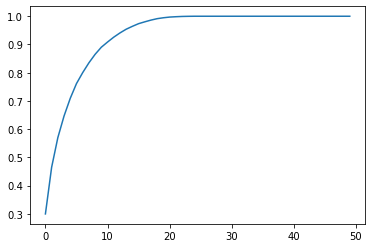

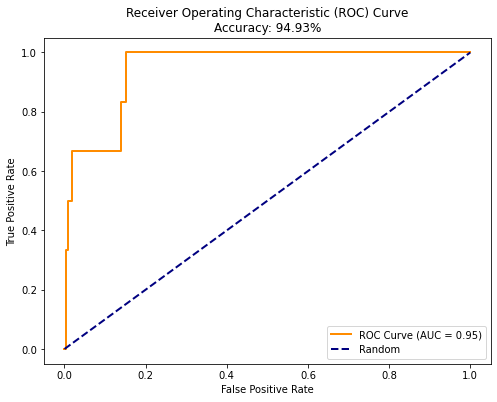

In [116]:
# Split the data into X and y
y = df_PKM2
X = X_best_PKM2

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training and test data set
X_train, X_test, y_train, y_test_PKM2 = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)
 
# Decide the number of PCA components based on the retained information
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(explained_variance)

# Determine the number of components needed to explain 90% of the variance
desired_variance = 0.90
num_components = (np.argmax(explained_variance >= desired_variance) + 1)

#loose components who have too little influence
pca=PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logr_model=LogisticRegression(class_weight={0: 1, 1: 10}) #weights have a lot of effects
logr_model.fit(X_train_pca,y_train)

y_pred_PKM2 = logr_model.predict(X_test_pca)
accuracy_PKM2 = accuracy_score(y_test_PKM2, y_pred_PKM2)
balanced_accuracy_PKM2=balanced_accuracy_score(y_test_PKM2, y_pred_PKM2)
print("Accuracy: {:.2f}%".format(accuracy_PKM2 * 100))
print("Balanced accuracy: {:.2f}%".format(balanced_accuracy_PKM2 * 100))

# evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test_PKM2, y_pred_PKM2))
print("\nClassification Report:\n", classification_report(y_test_PKM2, y_pred_PKM2))

# Plot ROC Curve
y_prob_PKM2 = logr_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_PKM2, y_prob_PKM2)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy_PKM2 * 100))
plt.legend(loc="lower right")
plt.show()


Accuracy: 87.76%
Balanced accuracy: 53.94%
Confusion Matrix:
 [[291  25]
 [ 16   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       316
           1       0.11      0.16      0.13        19

    accuracy                           0.88       335
   macro avg       0.53      0.54      0.53       335
weighted avg       0.90      0.88      0.89       335



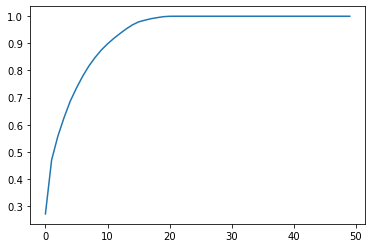

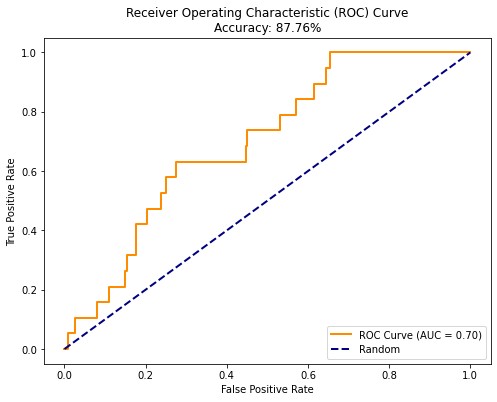

In [107]:

X=X_best_ERK2
y=df_ERK2 

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


# Split the data into training and test data set
X_train, X_test, y_train, y_test_ERK2 = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)
 
# Decide the number of PCA components based on the retained information
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(explained_variance)

# Determine the number of components needed to explain 90% of the variance
desired_variance = 0.90
num_components = (np.argmax(explained_variance >= desired_variance) + 1)

#loose components who have too little influence
pca=PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

logr_model=LogisticRegression(class_weight={0: 1, 1: 10})
logr_model.fit(X_train_pca,y_train)

y_pred_ERK2 = logr_model.predict(X_test_pca)
accuracy_ERK2  = accuracy_score(y_test_ERK2, y_pred_ERK2)
balanced_accuracy_ERK2 =balanced_accuracy_score(y_test_ERK2, y_pred_ERK2)
print("Accuracy: {:.2f}%".format(accuracy_ERK2  * 100))
print("Balanced accuracy: {:.2f}%".format(balanced_accuracy_ERK2  * 100))

# evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test_ERK2, y_pred_ERK2))
print("\nClassification Report:\n", classification_report(y_test_ERK2, y_pred_ERK2))


# Plot ROC Curve
y_prob_ERK2 = logr_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_ERK2, y_prob_ERK2)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy_ERK2  * 100))
plt.legend(loc="lower right")
plt.show()

In [108]:
#total for both 
accuracy= (accuracy_ERK2+ accuracy_PKM2)/2
balanced_accuracy=(balanced_accuracy_ERK2 + balanced_accuracy_PKM2)/2
print("Accuracy: {:.2f}%".format(accuracy  * 100))
print("Balanced accuracy: {:.2f}%".format(balanced_accuracy * 100))

Accuracy: 91.34%
Balanced accuracy: 67.50%
